# elastic 서버 세팅 및 연결확인

In [ ]:
!pip install elasticsearch

In [78]:
# 로컬에서 ngrok로 연결해둔 elasticsearch url 입력 연결

# ELASTIC_URL = "your elasticsearch url"
ELASTIC_URL = "https://d1b7-175-193-58-14.ngrok-free.app" # my url

In [93]:
from elasticsearch import Elasticsearch

# ngrok의 public URL을 사용하여 Elasticsearch 클라이언트 생성

es = Elasticsearch(ELASTIC_URL)

# Elasticsearch 클러스터 정보 확인
print(es.info())

# 인덱스 이름 정의
index_name = "clip-images"

{'name': '9d8f21caf5a2', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'rppCJcwpQ4-4YvNfXGH2eg', 'version': {'number': '7.17.23', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '61d76462eecaf09ada684d1b5d319b5ff6865a83', 'build_date': '2024-07-25T14:37:42.448799567Z', 'build_snapshot': False, 'lucene_version': '8.11.3', 'minimum_wire_compatibility_version': '6.8.0', 'minimum_index_compatibility_version': '6.0.0-beta1'}, 'tagline': 'You Know, for Search'}


<ipython-input-93-c7513a767e06>:8: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  print(es.info())


In [94]:
# 인덱스 생성 및 매핑 설정
if not es.indices.exists(index=index_name):
    mapping = {
        "mappings": {
            "properties": {
                "embedding": {
                    "type": "dense_vector",
                    "dims": 512  # CLIP 모델의 임베딩 차원 수
                },
                "image_path": {
                    "type": "keyword"
                }
            }
        }
    }
    es.indices.create(index=index_name, body=mapping)

<ipython-input-94-becf3c12aa2c>:2: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  if not es.indices.exists(index=index_name):
<ipython-input-94-becf3c12aa2c>:16: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.indices.create(index=index_name, body=mapping)


# Dataset 준비

In [ ]:
!wget -q https://github.com/kairess/toy-datasets/raw/master/Food-11.zip
!unzip -q Food-11.zip

replace __MACOSX/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# test 이미지 확인용

# from PIL import Image
# img = Image.open("test/Bread/0.jpg")
# img

# huggingface clip 모델 준비
[huggingface clip 모델 문서](https://huggingface.co/docs/transformers/model_doc/clip)

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

# 임베딩

## 이미지 임베딩 및 저장

In [88]:
import torch

def encode_image(image_path):
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features[0].numpy()

<ipython-input-88-6cc53573bb89>:20: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.index(index=index_name, body=doc)


ObjectApiResponse({'_index': 'clip-images', '_type': '_doc', '_id': 'OMUFopEBxyb712EhFLAp', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 3, '_primary_term': 1})

In [130]:
# 1개 저장 확인용
# 이미지 데이터
# image_path = "test/Bread/0.jpg"
# image_embedding = encode_image(image_path)

# Elasticsearch에 이미지 임베딩 저장
# doc = {
#     "image_path": image_path,
#     "embedding": image_embedding.tolist()
# }

# es.index(index=index_name, body=doc)

In [95]:
# test 밑 110장 모두저장
from glob import glob

img_list = sorted(glob("test/*/*.jpg"))

for image_path in img_list:
    image_embedding = encode_image(image_path)
    doc = {
      "image_path": image_path,
      "embedding": image_embedding.tolist()
    }

    es.index(index=index_name, body=doc)

<ipython-input-95-7810742b6f1f>:13: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.index(index=index_name, body=doc)


## 텍스트 임베딩

In [96]:
def encode_text(text):
    inputs = processor(text=[text], return_tensors="pt", padding=True)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    return text_features[0].numpy()

# 텍스트로 이미지 검색

In [99]:
def search_by_text(query_text, k=3):
    # 텍스트를 인코딩하여 쿼리 벡터 생성
    query_embedding = encode_text(query_text).tolist()

    # Elasticsearch 유사도 검색 쿼리 작성
    search_query = {
        "size": k,
        "query": {
            "script_score": {
                "query": {"match_all": {}},
                "script": {
                    "source": "cosineSimilarity(params.query_vector, 'embedding') + 1.0",
                    "params": {"query_vector": query_embedding}
                }
            }
        }
    }

    # Elasticsearch에서 검색 수행
    response = es.search(index=index_name, body=search_query)
    return response["hits"]["hits"]

In [129]:
# # 텍스트를 사용한 이미지 1장 테스트용
# results = search_by_text("A photo of meat")

# # 결과 출력
# for result in results:
#     print("Image Path:", result["_source"]["image_path"], "Score:", result["_score"])

# 테스트

In [113]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images(results):
    # 1행 3열로 설정
    num_images = len(results)
    cols = 3
    rows = 1

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))

    # 여러 이미지를 한 번에 표시
    for i, result in enumerate(results):
        img_path = result["_source"]["image_path"]
        img = mpimg.imread(img_path)

        # 이미지와 점수를 출력
        ax = axes[i]  # 인덱스에 따라 axes를 선택
        ax.imshow(img)
        ax.set_title(f"Image: {''.join(result['_source']['image_path'].split('/')[1:])}\nScore: {result['_score']:.4f}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

<ipython-input-99-858910e27f4c>:20: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index=index_name, body=search_query)


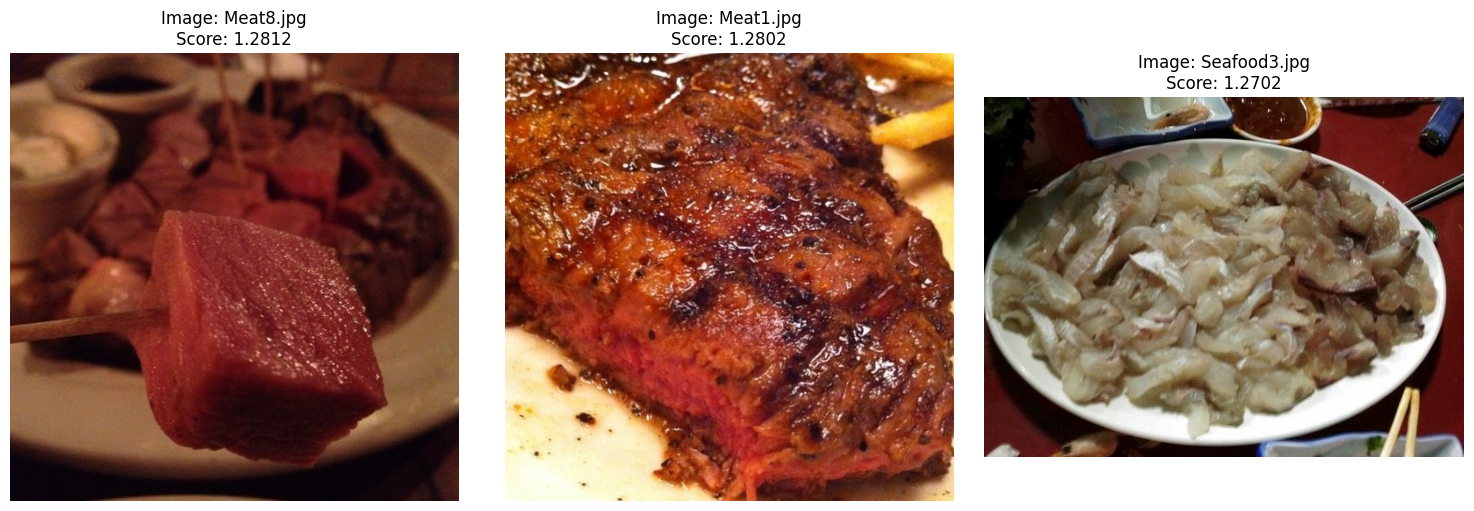

In [119]:
# 고기 검색
results = search_by_text("A photo of meat")
display_images(results)

<ipython-input-99-858910e27f4c>:20: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index=index_name, body=search_query)


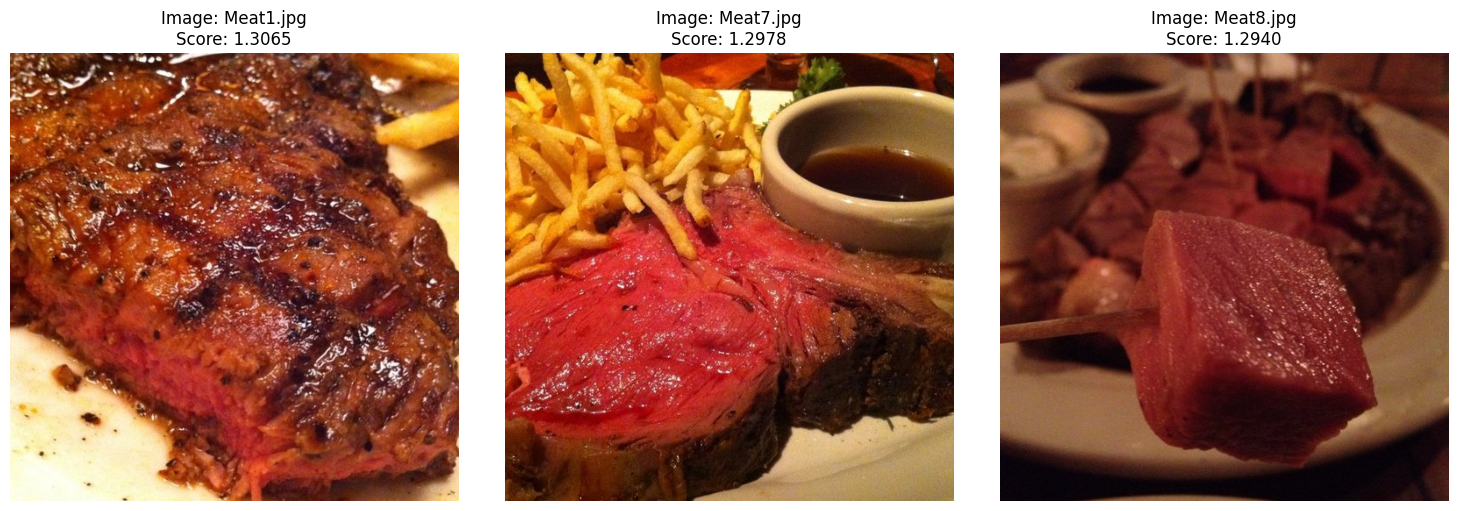

In [122]:
# 빨간색 고기 검색
results = search_by_text("red meat photo")
display_images(results)

<ipython-input-99-858910e27f4c>:20: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index=index_name, body=search_query)


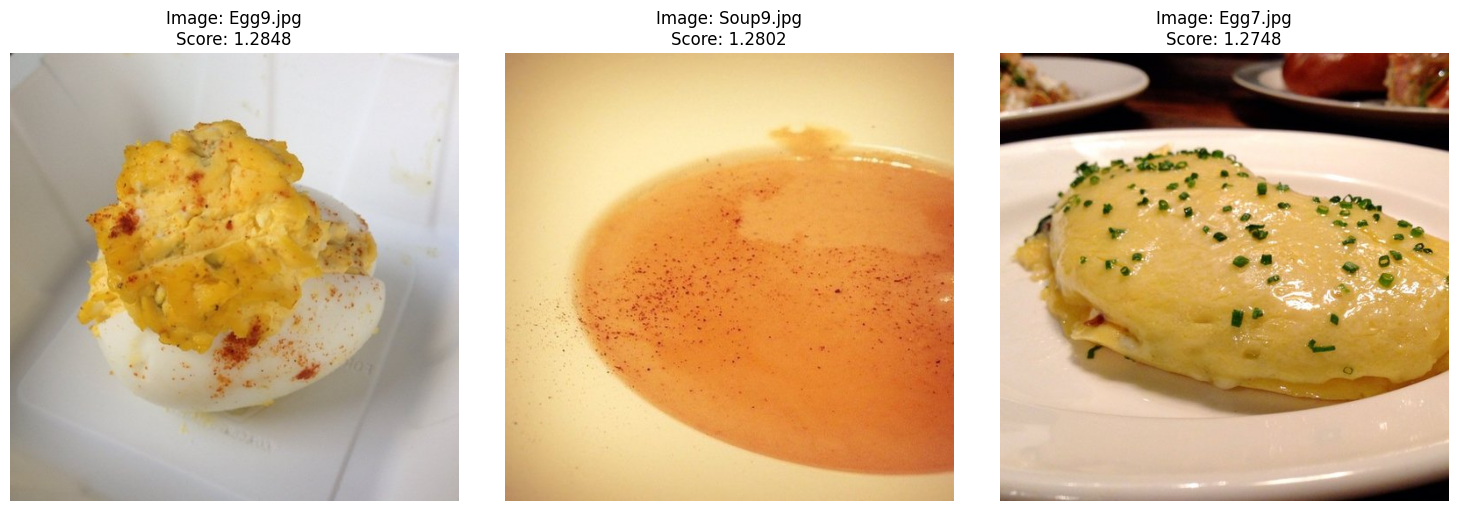

In [115]:
# 계란 검색
results = search_by_text("A photo of egg")
display_images(results)

<ipython-input-99-858910e27f4c>:20: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index=index_name, body=search_query)


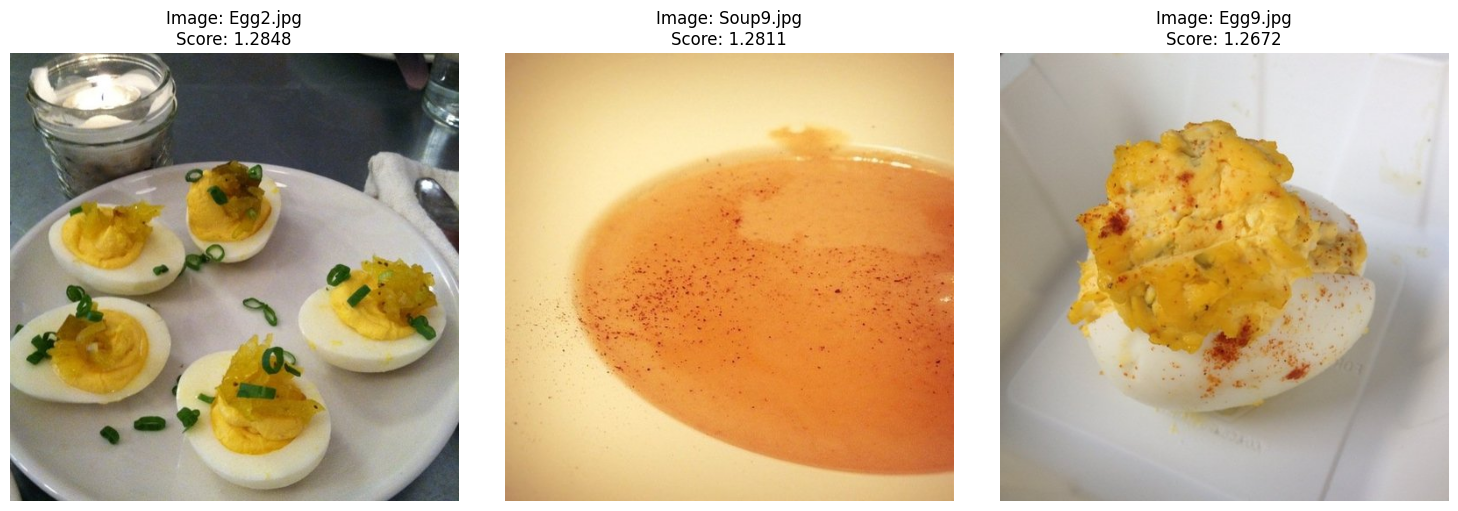

In [125]:
# 삶은 계란 검색
results = search_by_text("boiled egg photo")
display_images(results)

<ipython-input-99-858910e27f4c>:20: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index=index_name, body=search_query)


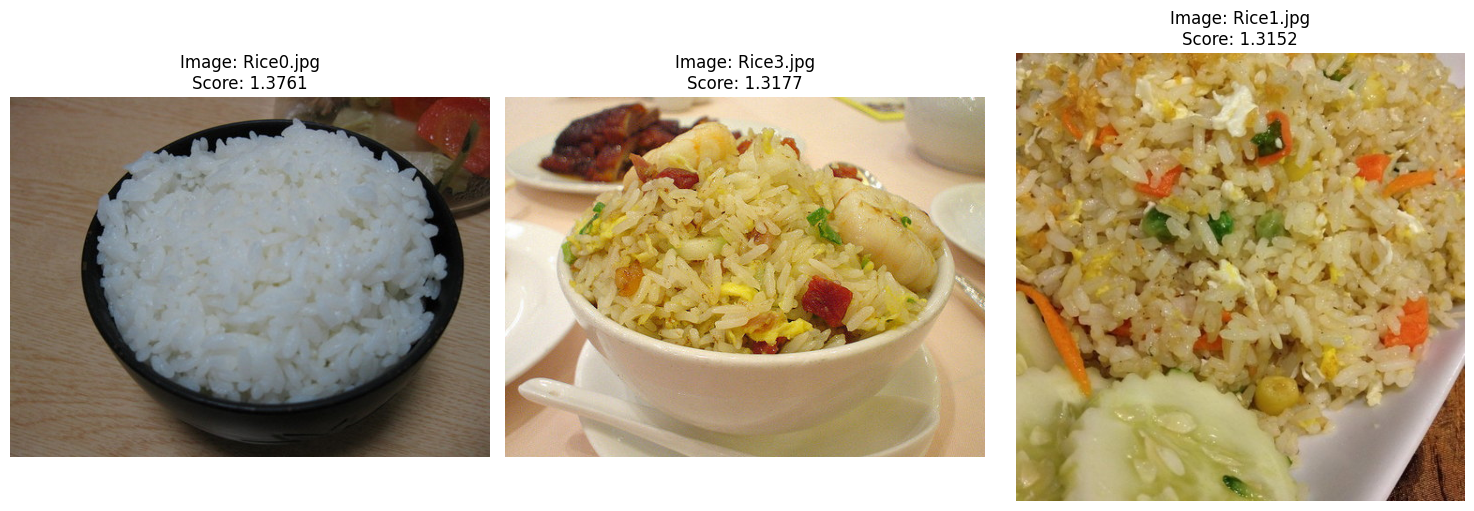

In [117]:
# 밥 검색
results = search_by_text("A photo of rice")
display_images(results)

<ipython-input-99-858910e27f4c>:20: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index=index_name, body=search_query)


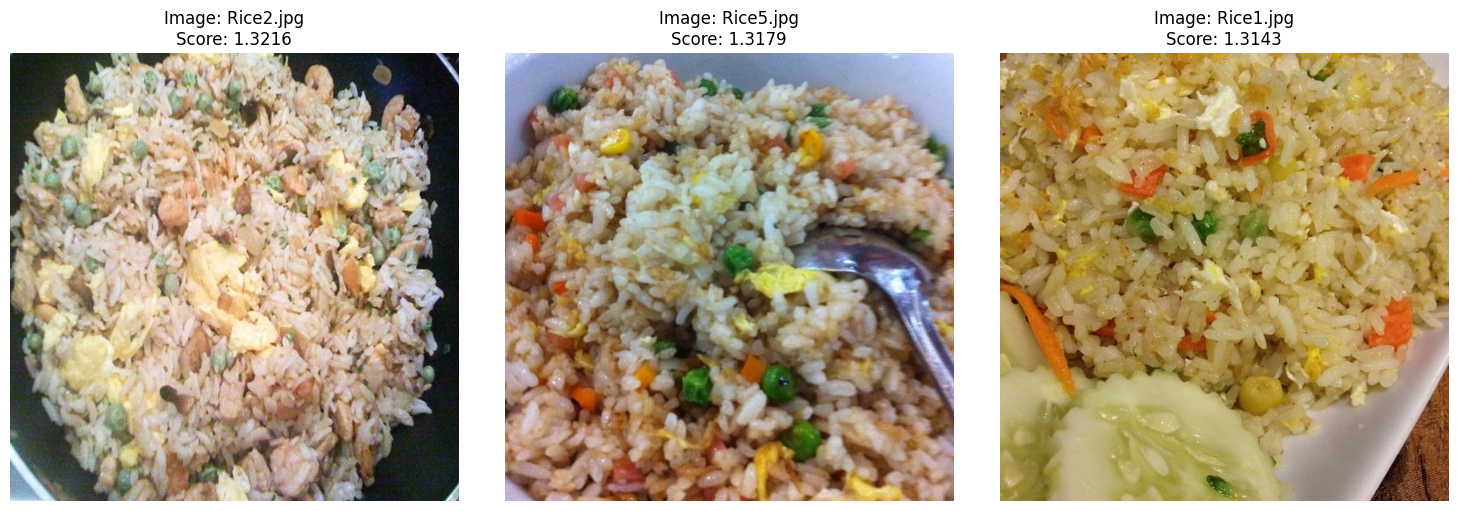

In [127]:
# 볶음밥 검색
results = search_by_text("fried rice")
display_images(results)